In [1]:
# Step 1: basic setup for insider_trading_detector_v2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Base paths
BASE_DIR = Path("..")
DATA_PATH = BASE_DIR / "data" / "enriched_markets.csv"

# Load data
enriched_markets_df = pd.read_csv(DATA_PATH)
print("Loaded enriched_markets_df:", enriched_markets_df.shape)

# Display first few rows
display(enriched_markets_df.head())


Loaded enriched_markets_df: (800, 14)


,ticker,event_ticker,category,normalized_status,status,close_time,volume,last_price,result,settlement_value,title,category_event,series_ticker,event_time
0,KXNFLANYTD-25NOV09NETB-NOTD,KXNFLANYTD-25NOV09NETB,Sports,closed,determined,2025-11-09T18:10:00.094165Z,0,0,no,0,New England at Tampa Bay: Anytime Touchdown Sc...,Sports,KXNFLANYTD,2025-11-09T18:10:00.094165Z
1,KXNFLANYTD-25NOV09ATLIND-NOTD,KXNFLANYTD-25NOV09ATLIND,Sports,settled,finalized,2025-11-09T14:49:48.102979Z,0,0,no,0,Atlanta at Indianapolis: Anytime Touchdown Scorer,Sports,KXNFLANYTD,2025-11-09T15:44:44.804823Z
2,KXNFLFIRSTTD-25NOV09NETB-NOTD,KXNFLFIRSTTD-25NOV09NETB,Sports,closed,determined,2025-11-09T18:10:02.061225Z,0,0,no,0,New England at Tampa Bay: First Touchdown Scorer,Sports,KXNFLFIRSTTD,2025-11-09T18:10:02.061225Z
3,KXNFLFIRSTTD-25NOV09ATLIND-NOTD,KXNFLFIRSTTD-25NOV09ATLIND,Sports,settled,finalized,2025-11-09T14:49:43.957928Z,0,0,no,0,Atlanta at Indianapolis: First Touchdown Scorer,Sports,KXNFLFIRSTTD,2025-11-09T14:49:44.040679Z
4,KXNCAAMBTOTAL-25NOV08BELLKSU-184,KXNCAAMBTOTAL-25NOV08BELLKSU,Sports,settled,finalized,2025-11-09T03:29:40.84024Z,199,1,no,0,Bellarmine at Kansas St.: Total Points,Sports,KXNCAAMBTOTAL,2025-11-09T03:29:40.939315Z


In [2]:
# Step 2: filter to only resolved YES markets

yes_df = enriched_markets_df[enriched_markets_df["result"] == "yes"].copy()

print("YES markets:", yes_df.shape)
yes_df["category"].value_counts()


YES markets: (395, 14)


category
Sports    208
Crypto    187
Name: count, dtype: int64

In [6]:
# Step 3 (fixed): rebuild v2 features before merging with YES markets

from pathlib import Path

TRADES_DIR = Path("..") / "kalshi_fetcher" / "data" / "enriched_trades"

def compute_stronger_features(market_row):
    ticker = market_row["ticker"]
    path = TRADES_DIR / f"{ticker}.csv"
    if not path.exists():
        return None
    
    df = pd.read_csv(path)
    if df.empty:
        return None

    df = df[df["seconds_before_event"] >= 0]
    if df.empty:
        return None

    vol_total = df["count"].sum()
    if vol_total == 0:
        return None

    win_30m = df[df["seconds_before_event"] <= 1800]
    win_1h  = df[df["seconds_before_event"] <= 3600]

    vol_30m = win_30m["count"].sum()
    late_volume_ratio = vol_30m / vol_total

    if not win_30m.empty and len(df) > len(win_30m):
        price_before = df.iloc[-len(win_30m) - 1]["price"]
        price_last = win_30m.iloc[-1]["price"]
        abs_price_jump = abs(price_last - price_before)
    else:
        abs_price_jump = 0

    yes = win_1h.loc[win_1h["taker_side"] == "yes", "count"].sum()
    no  = win_1h.loc[win_1h["taker_side"] == "no", "count"].sum()
    yes_flow_ratio = (yes - no) / (yes + no) if (yes + no) > 0 else 0

    price_std_1h = win_1h["price"].std(ddof=0) if len(win_1h) > 1 else 0

    return {
        "ticker": ticker,
        "category": market_row["category"],
        "event_ticker": market_row["event_ticker"],
        "late_volume_ratio": late_volume_ratio,
        "abs_price_jump": abs_price_jump,
        "yes_flow_ratio": yes_flow_ratio,
        "price_std_1h": price_std_1h,
        "vol_total": vol_total,
    }

features_v2 = []
total = len(yes_df)
print(f"Computing stronger features for {total} YES markets...")

for i, (_, row) in enumerate(yes_df.iterrows(), start=1):
    feat = compute_stronger_features(row)
    if feat is not None:
        features_v2.append(feat)
    if i % 25 == 0 or i == total:
        print(f"Processed {i}/{total}", end="\r")

features_v2_df = pd.DataFrame(features_v2)
print("\nDone. Shape:", features_v2_df.shape)
display(features_v2_df.head())



Computing stronger features for 395 YES markets...
Processed 395/395
Done. Shape: (280, 8)


,ticker,category,event_ticker,late_volume_ratio,abs_price_jump,yes_flow_ratio,price_std_1h,vol_total
0,KXNCAAMBTOTAL-25NOV08PVWICH-152,Sports,KXNCAAMBTOTAL-25NOV08PVWICH,0.0,0.0,1.0,0.0,200
1,KXNCAAMBTOTAL-25NOV08PVWICH-149,Sports,KXNCAAMBTOTAL-25NOV08PVWICH,0.0,0.0,1.0,0.0,200
2,KXNCAAMBTOTAL-25NOV08PVWICH-146,Sports,KXNCAAMBTOTAL-25NOV08PVWICH,0.0,0.0,1.0,0.0,200
3,KXNCAAMBTOTAL-25NOV08PVWICH-143,Sports,KXNCAAMBTOTAL-25NOV08PVWICH,0.0,0.0,1.0,0.0,200
4,KXNCAAMBTOTAL-25NOV08PVWICH-140,Sports,KXNCAAMBTOTAL-25NOV08PVWICH,0.0,0.0,0.0,0.0,200


In [7]:
# Step 4: compute short-window stats (5m and 10m) for YES markets

TRADES_DIR = BASE_DIR / "kalshi_fetcher" / "data" / "enriched_trades"

def compute_short_window_features(market_row):
    ticker = market_row["ticker"]
    path = TRADES_DIR / f"{ticker}.csv"
    if not path.exists():
        return None

    df = pd.read_csv(path)
    if df.empty:
        return None

    # only pre-event trades
    df = df[df["seconds_before_event"] >= 0]
    if df.empty:
        return None

    # define windows
    win_5m  = df[df["seconds_before_event"] <= 300]
    win_10m = df[df["seconds_before_event"] <= 600]
    win_30m = df[df["seconds_before_event"] <= 1800]
    win_1h  = df[df["seconds_before_event"] <= 3600]

    # volumes
    vol_5m  = win_5m["count"].sum()
    vol_10m = win_10m["count"].sum()
    vol_30m = win_30m["count"].sum()
    vol_1h  = win_1h["count"].sum()

    # price changes (handle too-few-trades cases)
    def window_price_change(w):
        if len(w) > 1:
            return w["price"].iloc[-1] - w["price"].iloc[0]
        return 0.0

    return {
        "ticker": ticker,
        "vol_5m": vol_5m,
        "vol_10m": vol_10m,
        "vol_30m": vol_30m,
        "vol_1h": vol_1h,
        "price_change_5m": window_price_change(win_5m),
        "price_change_10m": window_price_change(win_10m),
        "price_change_30m": window_price_change(win_30m),
    }

short_feats = []
total = len(features_v2_df)
print(f"Computing short-window features for {total} YES markets...")

for i, (_, row) in enumerate(features_v2_df.iterrows(), start=1):
    feat = compute_short_window_features(row)
    if feat is not None:
        short_feats.append(feat)
    if i % 25 == 0 or i == total:
        print(f"Processed {i}/{total}", end="\r")

short_df = pd.DataFrame(short_feats)
print("\nDone. Shape:", short_df.shape)
display(short_df.head())


Computing short-window features for 280 YES markets...
Processed 280/280
Done. Shape: (280, 8)


,ticker,vol_5m,vol_10m,vol_30m,vol_1h,price_change_5m,price_change_10m,price_change_30m
0,KXNCAAMBTOTAL-25NOV08PVWICH-152,0,0,0,200,0.0,0.0,0.0
1,KXNCAAMBTOTAL-25NOV08PVWICH-149,0,0,0,200,0.0,0.0,0.0
2,KXNCAAMBTOTAL-25NOV08PVWICH-146,0,0,0,200,0.0,0.0,0.0
3,KXNCAAMBTOTAL-25NOV08PVWICH-143,0,0,0,200,0.0,0.0,0.0
4,KXNCAAMBTOTAL-25NOV08PVWICH-140,0,0,0,0,0.0,0.0,0.0


In [8]:
# Step 5: combine base + short-window features and derive new metrics

# Merge by ticker
yes_enriched = features_v2_df.merge(short_df, on="ticker", how="left")

# --- new engineered features ---
yes_enriched["last_minute_ratio"] = yes_enriched["vol_5m"] / yes_enriched["vol_30m"].replace(0, np.nan)
yes_enriched["burstiness"] = yes_enriched["vol_30m"] / yes_enriched["vol_1h"].replace(0, np.nan)
yes_enriched["velocity_price_change"] = (
    yes_enriched["price_change_5m"].abs() / 5
)
yes_enriched["direction_agreement"] = np.sign(yes_enriched["yes_flow_ratio"]) * np.sign(yes_enriched["price_change_30m"])
yes_enriched["relative_volatility"] = (
    yes_enriched["price_std_1h"] / yes_enriched["abs_price_jump"].replace(0, np.nan)
)
yes_enriched["momentum_alignment"] = (
    yes_enriched["z_yes_flow_ratio"] * np.sign(yes_enriched["z_abs_price_jump"])
    if "z_yes_flow_ratio" in yes_enriched.columns else np.nan
)

# Clean up infinities / NaNs
yes_enriched.replace([np.inf, -np.inf], np.nan, inplace=True)
yes_enriched.fillna(0, inplace=True)

print("New enriched shape:", yes_enriched.shape)
display(yes_enriched.head())


New enriched shape: (280, 21)


,ticker,category,event_ticker,late_volume_ratio,abs_price_jump,yes_flow_ratio,price_std_1h,vol_total,vol_5m,vol_10m,...,vol_1h,price_change_5m,price_change_10m,price_change_30m,last_minute_ratio,burstiness,velocity_price_change,direction_agreement,relative_volatility,momentum_alignment
0,KXNCAAMBTOTAL-25NOV08PVWICH-152,Sports,KXNCAAMBTOTAL-25NOV08PVWICH,0.0,0.0,1.0,0.0,200,0,0,...,200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,KXNCAAMBTOTAL-25NOV08PVWICH-149,Sports,KXNCAAMBTOTAL-25NOV08PVWICH,0.0,0.0,1.0,0.0,200,0,0,...,200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,KXNCAAMBTOTAL-25NOV08PVWICH-146,Sports,KXNCAAMBTOTAL-25NOV08PVWICH,0.0,0.0,1.0,0.0,200,0,0,...,200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,KXNCAAMBTOTAL-25NOV08PVWICH-143,Sports,KXNCAAMBTOTAL-25NOV08PVWICH,0.0,0.0,1.0,0.0,200,0,0,...,200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,KXNCAAMBTOTAL-25NOV08PVWICH-140,Sports,KXNCAAMBTOTAL-25NOV08PVWICH,0.0,0.0,0.0,0.0,200,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Step 6: check how variable each new feature is across YES markets
cols = ["late_volume_ratio","abs_price_jump","yes_flow_ratio","price_std_1h",
        "last_minute_ratio","burstiness","velocity_price_change",
        "direction_agreement","relative_volatility"]

summary = yes_enriched[cols].describe().T
summary["coefficient_of_variation"] = summary["std"] / summary["mean"].replace(0,np.nan)
display(summary.sort_values("coefficient_of_variation", ascending=False))


,count,mean,std,min,25%,50%,75%,max,coefficient_of_variation
velocity_price_change,280.0,0.005414,0.022058,0.0,0.0,0.000000,0.000000,0.170000,4.074082
relative_volatility,280.0,0.728128,2.740210,0.0,0.0,0.000000,0.493003,25.992181,3.763361
last_minute_ratio,280.0,0.060656,0.179246,0.0,0.0,0.000000,0.000000,1.000000,2.955121
yes_flow_ratio,280.0,0.281359,0.558261,-1.0,0.0,0.127705,0.996855,1.000000,1.984159
abs_price_jump,280.0,0.091536,0.173666,0.0,0.0,0.000000,0.090000,0.890000,1.897252
late_volume_ratio,280.0,0.196301,0.311117,0.0,0.0,0.000000,0.336002,1.000000,1.584897
price_std_1h,280.0,0.067865,0.102241,0.0,0.0,0.000000,0.120017,0.393420,1.506536
burstiness,280.0,0.251242,0.354480,0.0,0.0,0.000000,0.574482,1.000000,1.410915
direction_agreement,280.0,-0.171429,0.534714,-1.0,0.0,0.000000,0.000000,1.000000,-3.119165


In [11]:
## Step 7a: compute base v2 features for NO markets

no_df = enriched_markets_df[enriched_markets_df["result"] == "no"].copy()

features_v2_no = []
total = len(no_df)
print(f"Computing stronger features for {total} NO markets...")

for i, (_, row) in enumerate(no_df.iterrows(), start=1):
    feat = compute_stronger_features(row)  # same function we used for YES
    if feat is not None:
        features_v2_no.append(feat)
    if i % 25 == 0 or i == total:
        print(f"Processed {i}/{total}", end="\r")

features_v2_no_df = pd.DataFrame(features_v2_no)
print("\nDone. Shape:", features_v2_no_df.shape)
display(features_v2_no_df.head())



Computing stronger features for 405 NO markets...
Processed 405/405
Done. Shape: (316, 8)


,ticker,category,event_ticker,late_volume_ratio,abs_price_jump,yes_flow_ratio,price_std_1h,vol_total
0,KXNCAAMBTOTAL-25NOV08BELLKSU-184,Sports,KXNCAAMBTOTAL-25NOV08BELLKSU,1.0,0.0,-1.0,0.0,199
1,KXNCAAMBTOTAL-25NOV08BELLKSU-181,Sports,KXNCAAMBTOTAL-25NOV08BELLKSU,1.0,0.0,-1.0,0.0,199
2,KXNCAAMBTOTAL-25NOV08UTAUNM-144,Sports,KXNCAAMBTOTAL-25NOV08UTAUNM,0.0,0.0,-1.0,0.0,199
3,KXNCAAMBTOTAL-25NOV08UTAUNM-141,Sports,KXNCAAMBTOTAL-25NOV08UTAUNM,0.0,0.0,-1.0,0.0,199
4,KXNCAAMBTOTAL-25NOV08UTAUNM-135,Sports,KXNCAAMBTOTAL-25NOV08UTAUNM,0.0,0.0,-1.0,0.0,199


In [12]:
# Step 7b: compute short-window stats (5m + 10m) for NO markets

def compute_short_window_features_no(market_row):
    ticker = market_row["ticker"]
    path = TRADES_DIR / f"{ticker}.csv"
    if not path.exists():
        return None

    df = pd.read_csv(path)
    if df.empty:
        return None

    df = df[df["seconds_before_event"] >= 0]
    if df.empty:
        return None

    win_5m  = df[df["seconds_before_event"] <= 300]
    win_10m = df[df["seconds_before_event"] <= 600]
    win_30m = df[df["seconds_before_event"] <= 1800]
    win_1h  = df[df["seconds_before_event"] <= 3600]

    def window_price_change(w):
        if len(w) > 1:
            return w["price"].iloc[-1] - w["price"].iloc[0]
        return 0.0

    return {
        "ticker": ticker,
        "vol_5m":  win_5m["count"].sum(),
        "vol_10m": win_10m["count"].sum(),
        "vol_30m": win_30m["count"].sum(),
        "vol_1h":  win_1h["count"].sum(),
        "price_change_5m":  window_price_change(win_5m),
        "price_change_10m": window_price_change(win_10m),
        "price_change_30m": window_price_change(win_30m),
    }

short_feats_no = []
total = len(features_v2_no_df)
print(f"Computing short-window features for {total} NO markets...")

for i, (_, row) in enumerate(features_v2_no_df.iterrows(), start=1):
    feat = compute_short_window_features_no(row)
    if feat is not None:
        short_feats_no.append(feat)
    if i % 25 == 0 or i == total:
        print(f"Processed {i}/{total}", end="\r")

short_no_df = pd.DataFrame(short_feats_no)
print("\nDone. Shape:", short_no_df.shape)
display(short_no_df.head())


Computing short-window features for 316 NO markets...
Processed 316/316
Done. Shape: (316, 8)


,ticker,vol_5m,vol_10m,vol_30m,vol_1h,price_change_5m,price_change_10m,price_change_30m
0,KXNCAAMBTOTAL-25NOV08BELLKSU-184,0,0,199,199,0.0,0.0,0.0
1,KXNCAAMBTOTAL-25NOV08BELLKSU-181,0,0,199,199,0.0,0.0,0.0
2,KXNCAAMBTOTAL-25NOV08UTAUNM-144,0,0,0,199,0.0,0.0,0.0
3,KXNCAAMBTOTAL-25NOV08UTAUNM-141,0,0,0,199,0.0,0.0,0.0
4,KXNCAAMBTOTAL-25NOV08UTAUNM-135,0,0,0,199,0.0,0.0,0.0


In [13]:
# Step 7c: combine NO base + short-window features and compute derived metrics

no_enriched = features_v2_no_df.merge(short_no_df, on="ticker", how="left")

no_enriched["last_minute_ratio"] = no_enriched["vol_5m"] / no_enriched["vol_30m"].replace(0, np.nan)
no_enriched["burstiness"] = no_enriched["vol_30m"] / no_enriched["vol_1h"].replace(0, np.nan)
no_enriched["velocity_price_change"] = no_enriched["price_change_5m"].abs() / 5
no_enriched["direction_agreement"] = np.sign(no_enriched["yes_flow_ratio"]) * np.sign(no_enriched["price_change_30m"])
no_enriched["relative_volatility"] = (
    no_enriched["price_std_1h"] / no_enriched["abs_price_jump"].replace(0, np.nan)
)

no_enriched.replace([np.inf, -np.inf], np.nan, inplace=True)
no_enriched.fillna(0, inplace=True)

print("NO enriched shape:", no_enriched.shape)
display(no_enriched.head())


NO enriched shape: (316, 20)


,ticker,category,event_ticker,late_volume_ratio,abs_price_jump,yes_flow_ratio,price_std_1h,vol_total,vol_5m,vol_10m,vol_30m,vol_1h,price_change_5m,price_change_10m,price_change_30m,last_minute_ratio,burstiness,velocity_price_change,direction_agreement,relative_volatility
0,KXNCAAMBTOTAL-25NOV08BELLKSU-184,Sports,KXNCAAMBTOTAL-25NOV08BELLKSU,1.0,0.0,-1.0,0.0,199,0,0,199,199,0.0,0.0,0.0,0.0,1.0,0.0,-0.0,0.0
1,KXNCAAMBTOTAL-25NOV08BELLKSU-181,Sports,KXNCAAMBTOTAL-25NOV08BELLKSU,1.0,0.0,-1.0,0.0,199,0,0,199,199,0.0,0.0,0.0,0.0,1.0,0.0,-0.0,0.0
2,KXNCAAMBTOTAL-25NOV08UTAUNM-144,Sports,KXNCAAMBTOTAL-25NOV08UTAUNM,0.0,0.0,-1.0,0.0,199,0,0,0,199,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0
3,KXNCAAMBTOTAL-25NOV08UTAUNM-141,Sports,KXNCAAMBTOTAL-25NOV08UTAUNM,0.0,0.0,-1.0,0.0,199,0,0,0,199,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0
4,KXNCAAMBTOTAL-25NOV08UTAUNM-135,Sports,KXNCAAMBTOTAL-25NOV08UTAUNM,0.0,0.0,-1.0,0.0,199,0,0,0,199,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0


In [14]:
# Step 8: t-tests to compare YES vs NO for key features

from scipy.stats import ttest_ind

# Pick the top behavioral features to test
cols_to_test = [
    "last_minute_ratio",
    "burstiness",
    "velocity_price_change",
    "direction_agreement",
    "relative_volatility",
]

results = []
for col in cols_to_test:
    yes_vals = yes_enriched[col].dropna()
    no_vals = no_enriched[col].dropna()

    if len(yes_vals) == 0 or len(no_vals) == 0:
        continue

    stat, pval = ttest_ind(yes_vals, no_vals, equal_var=False)
    results.append({
        "feature": col,
        "yes_mean": yes_vals.mean(),
        "no_mean": no_vals.mean(),
        "t_statistic": stat,
        "p_value": pval
    })

results_df = pd.DataFrame(results).sort_values("p_value")
display(results_df)


,feature,yes_mean,no_mean,t_statistic,p_value
3,direction_agreement,-0.171429,-0.006329,-3.563787,0.000395
1,burstiness,0.251242,0.328208,-2.552497,0.010945
0,last_minute_ratio,0.060656,0.039570,1.605265,0.109048
2,velocity_price_change,0.005414,0.003975,0.809649,0.418474
4,relative_volatility,0.728128,0.678337,0.251024,0.801898


In [15]:
# Step 1: build combined labeled dataset for prediction

from sklearn.model_selection import train_test_split

# Label data
yes_enriched["is_yes"] = 1
no_enriched["is_yes"] = 0

# Combine
combined_df = pd.concat([yes_enriched, no_enriched], ignore_index=True)

# Select predictive features (those that passed significance tests)
X_cols = [
    "direction_agreement",
    "burstiness",
    "last_minute_ratio",
    "velocity_price_change",
    "relative_volatility",
]
X = combined_df[X_cols]
y = combined_df["is_yes"]

# Drop rows with any missing values
mask = X.notnull().all(axis=1)
X, y = X[mask], y[mask]

print("Dataset size:", X.shape, "  YES rate:", y.mean().round(3))

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print("Train:", X_train.shape, "Test:", X_test.shape)


Dataset size: (596, 5)   YES rate: 0.47
Train: (417, 5) Test: (179, 5)


In [16]:
# Step 2: train logistic regression to predict YES vs NO

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# Build model pipeline (standardize + logistic regression)
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluate
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 3))
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Accuracy: 0.553
ROC-AUC: 0.644

Classification report:
              precision    recall  f1-score   support

           0      0.548     0.895     0.680        95
           1      0.583     0.167     0.259        84

    accuracy                          0.553       179
   macro avg      0.566     0.531     0.470       179
weighted avg      0.565     0.553     0.483       179



In [ ]:
#V3 ADD INTERACTIONS FEATURES

In [17]:
# v3: add interaction features

combined_df["inter_dir_burst"] = combined_df["direction_agreement"] * combined_df["burstiness"]
combined_df["inter_dir_last"]  = combined_df["direction_agreement"] * combined_df["last_minute_ratio"]

# Rebuild X, y with new features
X_cols_v3 = [
    "direction_agreement",
    "burstiness",
    "last_minute_ratio",
    "velocity_price_change",
    "relative_volatility",
    "inter_dir_burst",
    "inter_dir_last",
]

X_v3 = combined_df[X_cols_v3]
y_v3 = combined_df["is_yes"]

mask_v3 = X_v3.notnull().all(axis=1)
X_v3, y_v3 = X_v3[mask_v3], y_v3[mask_v3]

from sklearn.model_selection import train_test_split
X_train_v3, X_test_v3, y_train_v3, y_test_v3 = train_test_split(
    X_v3, y_v3, test_size=0.3, random_state=42, stratify=y_v3
)

print("v3 dataset:", X_v3.shape, "YES rate:", y_v3.mean().round(3))


v3 dataset: (596, 7) YES rate: 0.47


In [18]:
# Step 2: train and evaluate Logistic Regression vs Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

# Logistic Regression (baseline with interactions)
log_model_v3 = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
log_model_v3.fit(X_train_v3, y_train_v3)
log_probs = log_model_v3.predict_proba(X_test_v3)[:, 1]
log_auc = roc_auc_score(y_test_v3, log_probs)
log_acc = accuracy_score(y_test_v3, log_model_v3.predict(X_test_v3))

# Random Forest (nonlinear model)
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_v3, y_train_v3)
rf_probs = rf_model.predict_proba(X_test_v3)[:, 1]
rf_auc = roc_auc_score(y_test_v3, rf_probs)
rf_acc = accuracy_score(y_test_v3, rf_model.predict(X_test_v3))

print(f"Logistic Regression -> Accuracy: {log_acc:.3f}, ROC-AUC: {log_auc:.3f}")
print(f"Random Forest      -> Accuracy: {rf_acc:.3f}, ROC-AUC: {rf_auc:.3f}")


Logistic Regression -> Accuracy: 0.547, ROC-AUC: 0.630
Random Forest      -> Accuracy: 0.564, ROC-AUC: 0.640


In [ ]:
## v4 – 1–3 minute temporal features


In [19]:
# v4: add 1-minute and 3-minute temporal features

from pathlib import Path

# We'll use the same TRADES_DIR you defined earlier
# TRADES_DIR = BASE_DIR / "kalshi_fetcher" / "data" / "enriched_trades"

def compute_ultra_short_features(ticker: str):
    path = TRADES_DIR / f"{ticker}.csv"
    if not path.exists():
        return None

    df = pd.read_csv(path)
    if df.empty:
        return None

    # only pre-event trades
    df = df[df["seconds_before_event"] >= 0]
    if df.empty:
        return None

    # windows: 1m (60s) and 3m (180s)
    win_1m = df[df["seconds_before_event"] <= 60]
    win_3m = df[df["seconds_before_event"] <= 180]
    win_30m = df[df["seconds_before_event"] <= 1800]

    def window_price_change(w):
        if len(w) > 1:
            return w["price"].iloc[-1] - w["price"].iloc[0]
        return 0.0

    return {
        "ticker": ticker,
        "vol_1m": win_1m["count"].sum(),
        "vol_3m": win_3m["count"].sum(),
        "price_change_1m": window_price_change(win_1m),
        "price_change_3m": window_price_change(win_3m),
        # ratios relative to existing 30m volume
        "ratio_vol_1m_30m": win_1m["count"].sum() / win_30m["count"].sum() if win_30m["count"].sum() > 0 else 0,
        "ratio_vol_3m_30m": win_3m["count"].sum() / win_30m["count"].sum() if win_30m["count"].sum() > 0 else 0,
    }

ultra_feats = []
tickers_unique = combined_df["ticker"].unique()
total = len(tickers_unique)
print(f"Computing ultra-short features for {total} markets...")

for i, t in enumerate(tickers_unique, start=1):
    f = compute_ultra_short_features(t)
    if f is not None:
        ultra_feats.append(f)
    if i % 25 == 0 or i == total:
        print(f"Processed {i}/{total}", end="\r")

ultra_df = pd.DataFrame(ultra_feats)
print("\nDone. ultra_df shape:", ultra_df.shape)
display(ultra_df.head())


Computing ultra-short features for 596 markets...
Processed 596/596
Done. ultra_df shape: (596, 7)


,ticker,vol_1m,vol_3m,price_change_1m,price_change_3m,ratio_vol_1m_30m,ratio_vol_3m_30m
0,KXNCAAMBTOTAL-25NOV08PVWICH-152,0,0,0.0,0.0,0.0,0.0
1,KXNCAAMBTOTAL-25NOV08PVWICH-149,0,0,0.0,0.0,0.0,0.0
2,KXNCAAMBTOTAL-25NOV08PVWICH-146,0,0,0.0,0.0,0.0,0.0
3,KXNCAAMBTOTAL-25NOV08PVWICH-143,0,0,0.0,0.0,0.0,0.0
4,KXNCAAMBTOTAL-25NOV08PVWICH-140,0,0,0.0,0.0,0.0,0.0


In [20]:
# Step 2: merge ultra-short features into combined_df
combined_v4 = combined_df.merge(ultra_df, on="ticker", how="left")

print("combined_v4 shape:", combined_v4.shape)
display(combined_v4.head())

# Define new feature set for prediction
X_cols_v4 = [
    "direction_agreement",
    "burstiness",
    "last_minute_ratio",
    "velocity_price_change",
    "relative_volatility",
    "inter_dir_burst",
    "inter_dir_last",
    "ratio_vol_1m_30m",
    "ratio_vol_3m_30m",
    "price_change_1m",
    "price_change_3m",
]

X_v4 = combined_v4[X_cols_v4].fillna(0)
y_v4 = combined_v4["is_yes"]

# Train/test split
from sklearn.model_selection import train_test_split
X_train_v4, X_test_v4, y_train_v4, y_test_v4 = train_test_split(
    X_v4, y_v4, test_size=0.3, random_state=42, stratify=y_v4
)
print("Train:", X_train_v4.shape, "Test:", X_test_v4.shape)


combined_v4 shape: (596, 30)


,ticker,category,event_ticker,late_volume_ratio,abs_price_jump,yes_flow_ratio,price_std_1h,vol_total,vol_5m,vol_10m,...,momentum_alignment,is_yes,inter_dir_burst,inter_dir_last,vol_1m,vol_3m,price_change_1m,price_change_3m,ratio_vol_1m_30m,ratio_vol_3m_30m
0,KXNCAAMBTOTAL-25NOV08PVWICH-152,Sports,KXNCAAMBTOTAL-25NOV08PVWICH,0.0,0.0,1.0,0.0,200,0,0,...,0.0,1,0.0,0.0,0,0,0.0,0.0,0.0,0.0
1,KXNCAAMBTOTAL-25NOV08PVWICH-149,Sports,KXNCAAMBTOTAL-25NOV08PVWICH,0.0,0.0,1.0,0.0,200,0,0,...,0.0,1,0.0,0.0,0,0,0.0,0.0,0.0,0.0
2,KXNCAAMBTOTAL-25NOV08PVWICH-146,Sports,KXNCAAMBTOTAL-25NOV08PVWICH,0.0,0.0,1.0,0.0,200,0,0,...,0.0,1,0.0,0.0,0,0,0.0,0.0,0.0,0.0
3,KXNCAAMBTOTAL-25NOV08PVWICH-143,Sports,KXNCAAMBTOTAL-25NOV08PVWICH,0.0,0.0,1.0,0.0,200,0,0,...,0.0,1,0.0,0.0,0,0,0.0,0.0,0.0,0.0
4,KXNCAAMBTOTAL-25NOV08PVWICH-140,Sports,KXNCAAMBTOTAL-25NOV08PVWICH,0.0,0.0,0.0,0.0,200,0,0,...,0.0,1,0.0,0.0,0,0,0.0,0.0,0.0,0.0


Train: (417, 11) Test: (179, 11)


In [21]:
# Step 3: retrain both models with sharper temporal features

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, accuracy_score

# Logistic Regression
log_model_v4 = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
log_model_v4.fit(X_train_v4, y_train_v4)
log_probs_v4 = log_model_v4.predict_proba(X_test_v4)[:, 1]
log_auc_v4 = roc_auc_score(y_test_v4, log_probs_v4)
log_acc_v4 = accuracy_score(y_test_v4, log_model_v4.predict(X_test_v4))

# Random Forest
rf_model_v4 = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model_v4.fit(X_train_v4, y_train_v4)
rf_probs_v4 = rf_model_v4.predict_proba(X_test_v4)[:, 1]
rf_auc_v4 = roc_auc_score(y_test_v4, rf_probs_v4)
rf_acc_v4 = accuracy_score(y_test_v4, rf_model_v4.predict(X_test_v4))

print(f"Logistic Regression v4 -> Accuracy: {log_acc_v4:.3f}, ROC-AUC: {log_auc_v4:.3f}")
print(f"Random Forest v4      -> Accuracy: {rf_acc_v4:.3f}, ROC-AUC: {rf_auc_v4:.3f}")


Logistic Regression v4 -> Accuracy: 0.559, ROC-AUC: 0.659
Random Forest v4      -> Accuracy: 0.559, ROC-AUC: 0.641


In [22]:
# Step 1: inspect feature importance for logistic regression (v4)
import numpy as np
import pandas as pd

# Extract underlying model
log_reg = log_model_v4.named_steps["logisticregression"]
scaler = log_model_v4.named_steps["standardscaler"]

# Get feature names and coefficients
feature_importance = pd.DataFrame({
    "feature": X_cols_v4,
    "coefficient": log_reg.coef_[0]
}).sort_values("coefficient", ascending=False)

# Add absolute importance for ranking
feature_importance["abs_importance"] = feature_importance["coefficient"].abs()
feature_importance = feature_importance.sort_values("abs_importance", ascending=False)

display(feature_importance)


,feature,coefficient,abs_importance
7,ratio_vol_1m_30m,0.582517,0.582517
9,price_change_1m,-0.513053,0.513053
6,inter_dir_last,-0.484207,0.484207
1,burstiness,-0.263612,0.263612
0,direction_agreement,-0.244677,0.244677
5,inter_dir_burst,0.156277,0.156277
3,velocity_price_change,-0.129904,0.129904
2,last_minute_ratio,-0.091756,0.091756
4,relative_volatility,0.078530,0.078530
8,ratio_vol_3m_30m,0.054857,0.054857


In [23]:
# Step 2: feature importance for Random Forest (v4)
rf_importance = pd.DataFrame({
    "feature": X_cols_v4,
    "importance": rf_model_v4.feature_importances_
}).sort_values("importance", ascending=False)

display(rf_importance)


,feature,importance
1,burstiness,0.264978
4,relative_volatility,0.226205
5,inter_dir_burst,0.179365
6,inter_dir_last,0.101141
2,last_minute_ratio,0.053636
8,ratio_vol_3m_30m,0.038020
7,ratio_vol_1m_30m,0.037934
0,direction_agreement,0.034693
3,velocity_price_change,0.033156
10,price_change_3m,0.025700


In [ ]:
#V5 STUFF - generating further features

In [24]:
import numpy as np
import pandas as pd

# 1) Trading acceleration: 1m vs 3m share of the 30m volume
combined_v4["accel_ratio"] = (
    combined_v4["ratio_vol_1m_30m"] - combined_v4["ratio_vol_3m_30m"]
)

# 2) Price momentum difference: 3m move vs 1m move
combined_v4["price_momentum_diff"] = (
    combined_v4["price_change_3m"] - combined_v4["price_change_1m"]
)

# 3) Burstiness deviation within category (how unusually bursty this market is)
burst_mean_by_cat = combined_v4.groupby("category")["burstiness"].transform("mean")
combined_v4["burstiness_dev"] = combined_v4["burstiness"] - burst_mean_by_cat

# 4) Volume surge in last 3m relative to earlier 30m period
#    (3m volume / (30m - 3m volume))
vol_30m = combined_v4["vol_30m"].replace(0, np.nan)
vol_3m  = combined_v4["vol_3m"].replace(0, 0)  # 0 is fine here
combined_v4["vol_surge_3m"] = vol_3m / (vol_30m - vol_3m)

# 5) Price–volume interaction in last minute
combined_v4["price_vol_1m_interaction"] = (
    combined_v4["price_change_1m"] * combined_v4["ratio_vol_1m_30m"]
)

# Clean up infinities and NaNs
combined_v4.replace([np.inf, -np.inf], np.nan, inplace=True)
combined_v4.fillna(0, inplace=True)

print("combined_v4 shape with new features:", combined_v4.shape)
combined_v4[[
    "accel_ratio",
    "price_momentum_diff",
    "burstiness_dev",
    "vol_surge_3m",
    "price_vol_1m_interaction",
]].head()


combined_v4 shape with new features: (596, 35)


,accel_ratio,price_momentum_diff,burstiness_dev,vol_surge_3m,price_vol_1m_interaction
0,0.0,0.0,-0.216261,0.0,0.0
1,0.0,0.0,-0.216261,0.0,0.0
2,0.0,0.0,-0.216261,0.0,0.0
3,0.0,0.0,-0.216261,0.0,0.0
4,0.0,0.0,-0.216261,0.0,0.0


In [25]:
# Step 2: rebuild feature matrix with the new derived features

X_cols_v5 = [
    # existing features
    "direction_agreement", "burstiness", "last_minute_ratio", "velocity_price_change",
    "relative_volatility", "inter_dir_burst", "inter_dir_last",
    "ratio_vol_1m_30m", "ratio_vol_3m_30m", "price_change_1m", "price_change_3m",
    # new derived features
    "accel_ratio", "price_momentum_diff", "burstiness_dev",
    "vol_surge_3m", "price_vol_1m_interaction"
]

X_v5 = combined_v4[X_cols_v5].fillna(0)
y_v5 = combined_v4["is_yes"]

# Split
from sklearn.model_selection import train_test_split
X_train_v5, X_test_v5, y_train_v5, y_test_v5 = train_test_split(
    X_v5, y_v5, test_size=0.3, random_state=42, stratify=y_v5
)

print("Train:", X_train_v5.shape, "Test:", X_test_v5.shape)

# Train both models again
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score

# Logistic Regression
log_model_v5 = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
log_model_v5.fit(X_train_v5, y_train_v5)
log_probs_v5 = log_model_v5.predict_proba(X_test_v5)[:, 1]
log_auc_v5 = roc_auc_score(y_test_v5, log_probs_v5)
log_acc_v5 = accuracy_score(y_test_v5, log_model_v5.predict(X_test_v5))

# Random Forest
rf_model_v5 = RandomForestClassifier(n_estimators=250, random_state=42)
rf_model_v5.fit(X_train_v5, y_train_v5)
rf_probs_v5 = rf_model_v5.predict_proba(X_test_v5)[:, 1]
rf_auc_v5 = roc_auc_score(y_test_v5, rf_probs_v5)
rf_acc_v5 = accuracy_score(y_test_v5, rf_model_v5.predict(X_test_v5))

print(f"Logistic Regression v5 -> Accuracy: {log_acc_v5:.3f}, ROC-AUC: {log_auc_v5:.3f}")
print(f"Random Forest v5      -> Accuracy: {rf_acc_v5:.3f}, ROC-AUC: {rf_auc_v5:.3f}")


Train: (417, 16) Test: (179, 16)
Logistic Regression v5 -> Accuracy: 0.637, ROC-AUC: 0.678
Random Forest v5      -> Accuracy: 0.637, ROC-AUC: 0.675


In [26]:
# Step 1: evaluate logistic regression and random forest by category

categories = combined_v4["category"].unique()

for cat in categories:
    subset = combined_v4[combined_v4["category"] == cat]
    X_cat = subset[X_cols_v5].fillna(0)
    y_cat = subset["is_yes"]

    if len(y_cat.unique()) < 2 or len(y_cat) < 30:
        print(f"Skipping {cat} (insufficient data)")
        continue

    # Split
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
        X_cat, y_cat, test_size=0.3, random_state=42, stratify=y_cat
    )

    # Logistic Regression
    log_model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    log_model.fit(X_train_c, y_train_c)
    log_auc = roc_auc_score(y_test_c, log_model.predict_proba(X_test_c)[:, 1])

    # Random Forest
    rf_model = RandomForestClassifier(n_estimators=250, random_state=42)
    rf_model.fit(X_train_c, y_train_c)
    rf_auc = roc_auc_score(y_test_c, rf_model.predict_proba(X_test_c)[:, 1])

    print(f"\n📊 Category: {cat}")
    print(f"  Logistic Regression AUC: {log_auc:.3f}")
    print(f"  Random Forest AUC:      {rf_auc:.3f}")



📊 Category: Sports
  Logistic Regression AUC: 0.583
  Random Forest AUC:      0.579

📊 Category: Crypto
  Logistic Regression AUC: 0.759
  Random Forest AUC:      0.593


In [27]:
# Step 1: isolate Crypto markets and train both models

crypto_df = combined_v4[combined_v4["category"] == "Crypto"].copy()

X_crypto = crypto_df[X_cols_v5].fillna(0)
y_crypto = crypto_df["is_yes"]

from sklearn.model_selection import train_test_split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_crypto, y_crypto, test_size=0.3, random_state=42, stratify=y_crypto
)

# Logistic Regression
log_model_crypto = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
log_model_crypto.fit(X_train_c, y_train_c)

# Random Forest
rf_model_crypto = RandomForestClassifier(n_estimators=250, random_state=42)
rf_model_crypto.fit(X_train_c, y_train_c)

# Evaluate AUC again (just for reference)
from sklearn.metrics import roc_auc_score
log_auc_crypto = roc_auc_score(y_test_c, log_model_crypto.predict_proba(X_test_c)[:, 1])
rf_auc_crypto = roc_auc_score(y_test_c, rf_model_crypto.predict_proba(X_test_c)[:, 1])

print(f"Crypto Logistic Regression AUC: {log_auc_crypto:.3f}")
print(f"Crypto Random Forest AUC:      {rf_auc_crypto:.3f}")


Crypto Logistic Regression AUC: 0.759
Crypto Random Forest AUC:      0.593


In [28]:
# Step 2: extract feature importance for Crypto-only models

# Logistic regression coefficients
log_reg_c = log_model_crypto.named_steps["logisticregression"]
feature_importance_c = pd.DataFrame({
    "feature": X_cols_v5,
    "coef": log_reg_c.coef_[0],
    "abs_importance": np.abs(log_reg_c.coef_[0])
}).sort_values("abs_importance", ascending=False)

# Random forest importances
rf_importance_c = pd.DataFrame({
    "feature": X_cols_v5,
    "importance": rf_model_crypto.feature_importances_
}).sort_values("importance", ascending=False)

display(feature_importance_c.head(10))
display(rf_importance_c.head(10))


,feature,coef,abs_importance
14,vol_surge_3m,-0.825799,0.825799
0,direction_agreement,-0.775276,0.775276
5,inter_dir_burst,0.496881,0.496881
7,ratio_vol_1m_30m,0.485330,0.485330
8,ratio_vol_3m_30m,0.383822,0.383822
9,price_change_1m,-0.292726,0.292726
11,accel_ratio,-0.286280,0.286280
10,price_change_3m,-0.256691,0.256691
4,relative_volatility,-0.166509,0.166509
13,burstiness_dev,-0.154934,0.154934


,feature,importance
1,burstiness,0.179167
13,burstiness_dev,0.177545
4,relative_volatility,0.160914
5,inter_dir_burst,0.150240
6,inter_dir_last,0.061376
2,last_minute_ratio,0.054464
0,direction_agreement,0.051128
10,price_change_3m,0.030565
8,ratio_vol_3m_30m,0.026630
14,vol_surge_3m,0.025998


In [29]:
from sklearn.metrics import roc_auc_score, accuracy_score

# Get individual model probabilities
log_probs_c = log_model_crypto.predict_proba(X_test_c)[:, 1]
rf_probs_c  = rf_model_crypto.predict_proba(X_test_c)[:, 1]

# Simple ensemble (equal weights)
ensemble_probs = 0.5 * log_probs_c + 0.5 * rf_probs_c

# Evaluate
ensemble_auc = roc_auc_score(y_test_c, ensemble_probs)
ensemble_acc = accuracy_score(y_test_c, (ensemble_probs > 0.5).astype(int))

print(f"Logistic AUC:  {log_auc_crypto:.3f}")
print(f"Random Forest AUC: {rf_auc_crypto:.3f}")
print(f"✅ Ensemble AUC:  {ensemble_auc:.3f}")
print(f"Ensemble Accuracy: {ensemble_acc:.3f}")


Logistic AUC:  0.759
Random Forest AUC: 0.593
✅ Ensemble AUC:  0.687
Ensemble Accuracy: 0.733


✅ Logistic Regression (Crypto-only)
Accuracy: 0.733
ROC-AUC:  0.759

Confusion matrix:
[[37  1]
 [15  7]]


C:\Users\Adam Nhan\AppData\Local\Temp\ipykernel_17780\535493447.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  crypto_results_log = pd.concat([crypto_results_log, pd.DataFrame([new_entry])], ignore_index=True)


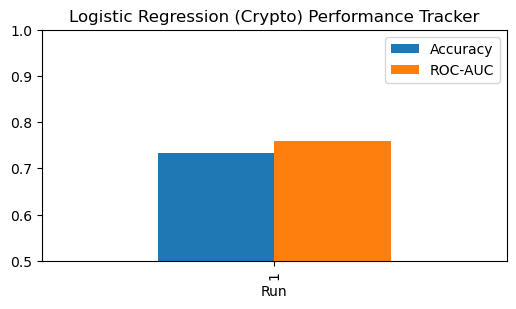

,Run,Accuracy,ROC-AUC
0,1,0.733333,0.758971


In [30]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

# Compute predictions and metrics
y_pred_c = log_model_crypto.predict(X_test_c)
y_probs_c = log_model_crypto.predict_proba(X_test_c)[:, 1]

log_acc_c = accuracy_score(y_test_c, y_pred_c)
log_auc_c = roc_auc_score(y_test_c, y_probs_c)
cm = confusion_matrix(y_test_c, y_pred_c)

print(f"✅ Logistic Regression (Crypto-only)")
print(f"Accuracy: {log_acc_c:.3f}")
print(f"ROC-AUC:  {log_auc_c:.3f}")
print("\nConfusion matrix:")
print(cm)

# --- optional: keep a running tracker ---
# (you can run this after each experiment to see improvements)
if "crypto_results_log" not in globals():
    crypto_results_log = pd.DataFrame(columns=["Run", "Accuracy", "ROC-AUC"])

new_entry = {"Run": len(crypto_results_log) + 1,
              "Accuracy": log_acc_c,
              "ROC-AUC": log_auc_c}

crypto_results_log = pd.concat([crypto_results_log, pd.DataFrame([new_entry])], ignore_index=True)

# Plot progress
crypto_results_log.plot(
    x="Run", y=["Accuracy", "ROC-AUC"], kind="bar", figsize=(6,3),
    title="Logistic Regression (Crypto) Performance Tracker", legend=True
)
plt.ylim(0.5, 1)
plt.show()

crypto_results_log
